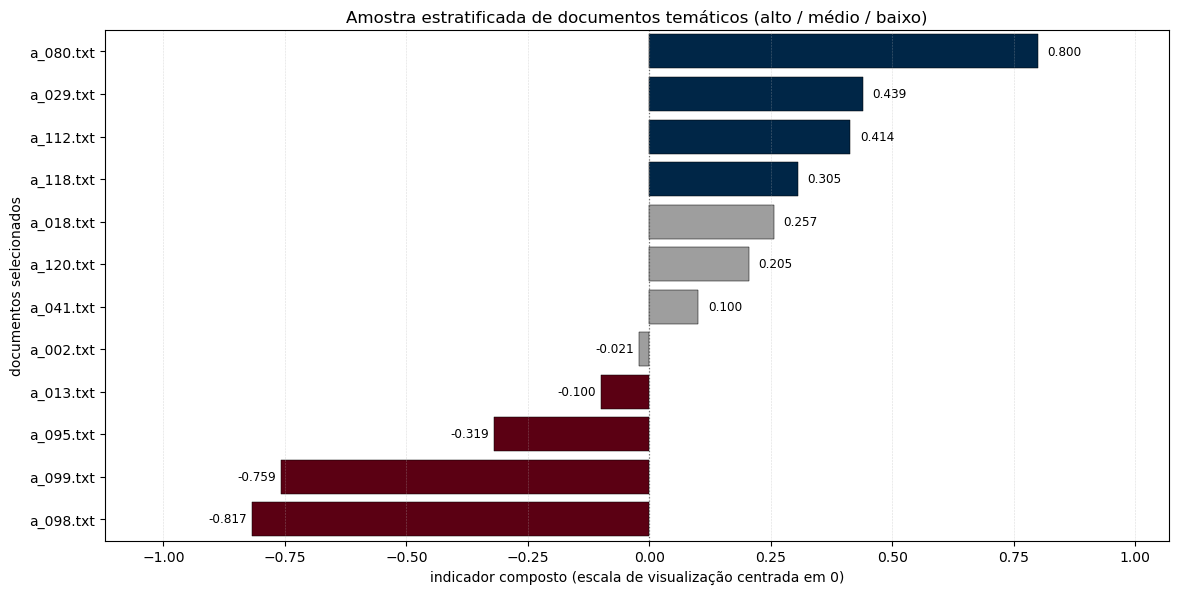

,file_name,text,bm25,semantic_cosine,coverage,diversity,bm25_z,semantic_z,coverage_z,diversity_z,wsm,wsm_vis,stratum
0,a_080.txt,ementa e acórdão inteiro teor do acórdão - pág...,20.566473,0.005824,0.161878,0.771890,1.395494,3.819997,1.168210,1.059701,1.860850,0.799976,alto
1,a_029.txt,ementa e acórdão inteiro teor do acórdão - pág...,23.847310,0.003929,0.155873,0.617771,1.861493,1.341427,0.939519,-0.054990,1.021862,0.439296,alto
2,a_112.txt,ementa e acórdão inteiro teor do acórdão - pág...,25.448069,0.004127,0.102201,0.800848,2.088859,1.599553,-1.104663,1.269146,0.963224,0.414088,alto
3,a_118.txt,ementa e acórdão inteiro teor do acórdão - pág...,10.825374,0.003561,0.160509,0.743245,0.011902,0.859941,1.116069,0.852523,0.710109,0.305274,alto
4,a_018.txt,ementa e acórdão inteiro teor do acórdão - pág...,8.361443,0.003186,0.155130,0.825211,-0.338066,0.369203,0.911206,1.445355,0.596924,0.256617,medio
5,a_120.txt,ementa e acórdão inteiro teor do acórdão - pág...,11.028957,0.004015,0.142498,0.623282,0.040818,1.453389,0.430096,-0.015127,0.477294,0.205188,medio
6,a_041.txt,ementa e acórdão inteiro teor do acórdão - pág...,13.286908,0.003122,0.139559,0.621331,0.361530,0.284455,0.318159,-0.029240,0.233726,0.100478,medio
7,a_002.txt,ementa e acórdão inteiro teor do acórdão - pág...,5.050463,0.003304,0.155293,0.510592,-0.808346,0.522474,0.917414,-0.830179,-0.049659,-0.021348,medio
8,a_013.txt,ementa e acórdão inteiro teor do acórdão - pág...,6.809449,0.003017,0.138824,0.513240,-0.558506,0.147645,0.290153,-0.811022,-0.232932,-0.100137,baixo
9,a_095.txt,ementa e acórdão inteiro teor do acórdão - pág...,3.283644,0.001442,0.103348,0.772395,-1.059299,-1.913243,-1.060974,1.063355,-0.742540,-0.319217,baixo


In [1]:
from pathlib import Path
import json
import math
import shutil
import pandas as pd
import matplotlib.pyplot as plt

config_path = (
    Path.home()
    / "Documents"
    / "jurimetria_aved_stf"
    / "config"
    / "project_config.json"
)
config = json.loads(config_path.read_text(encoding="utf-8"))

ranked_dir   = Path(config["paths"]["ranked_dir"]).expanduser()
thematic_dir = Path(config["paths"]["thematic_dir"]).expanduser()
master_dir   = Path(config["paths"]["master_dir"]).expanduser()
figures_dir  = Path(config["paths"]["figures_dir"]).expanduser()

master_dir.mkdir(parents=True, exist_ok=True)
figures_dir.mkdir(parents=True, exist_ok=True)

sample_texts_dir = master_dir / "sample_texts"
sample_texts_dir.mkdir(parents=True, exist_ok=True)

ranking_path = ranked_dir / "thematic_ranking.csv"
df = pd.read_csv(ranking_path)

if "wsm" not in df.columns or "wsm_vis" not in df.columns:
    raise RuntimeError("O arquivo de ranking não tem 'wsm' ou 'wsm_vis'. Rode o notebook 5 antes.")

df = df.sort_values(by="wsm", ascending=False).reset_index(drop=True)

n_docs = len(df)
if n_docs == 0:
    raise SystemExit("Nenhum documento temático encontrado para amostragem.")

# estratos: alto (0–20%), médio (20–80%), baixo (80–100%)
p20 = int(math.floor(n_docs * 0.20))
p80 = int(math.floor(n_docs * 0.80))

p20 = max(1, p20)
p80 = max(p20 + 1, p80)

df_A = df.iloc[:p20].copy()
df_A["stratum"] = "alto"

df_B = df.iloc[p20:p80].copy()
df_B["stratum"] = "medio"

df_C = df.iloc[p80:].copy()
df_C["stratum"] = "baixo"

# tamanho da amostra: ≈10%, com equivalência por estrato mesmo que total ≥10%
target_total = math.ceil(n_docs * 0.10)
existing_strata = [s for s in [df_A, df_B, df_C] if len(s) > 0]
n_strata = len(existing_strata)

per_stratum = math.ceil(target_total / n_strata)
per_stratum = max(per_stratum, 1)

samples = []

if len(df_A) > 0:
    k = min(per_stratum, len(df_A))
    samples.append(df_A.sample(n=k, random_state=42))

if len(df_B) > 0:
    k = min(per_stratum, len(df_B))
    samples.append(df_B.sample(n=k, random_state=42))

if len(df_C) > 0:
    k = min(per_stratum, len(df_C))
    samples.append(df_C.sample(n=k, random_state=42))

df_sample = pd.concat(samples, ignore_index=True)
df_sample = df_sample.sort_values(by="wsm", ascending=False).reset_index(drop=True)

sample_csv = master_dir / "thematic_sample.csv"
df_sample.to_csv(sample_csv, index=False)

try:
    df_sample.to_parquet(master_dir / "thematic_sample.parquet", index=False)
except Exception as e:
    print("Não foi possível salvar parquet da amostra:", e)

for row in df_sample.itertuples():
    txt_name = row.file_name
    src = thematic_dir / txt_name
    if src.exists():
        dst = sample_texts_dir / txt_name
        try:
            shutil.copy2(src, dst)
        except Exception:
            dst.write_text(src.read_text(encoding="utf-8"), encoding="utf-8")

# gráfico da amostra
MAX_LABEL = 65
display_labels = []
for name in df_sample["file_name"]:
    if len(name) <= MAX_LABEL:
        display_labels.append(name)
    else:
        display_labels.append(name[:MAX_LABEL - 3] + "...")

n_sel = len(df_sample)
height = max(4, 0.4 * n_sel + 1.0)

fig, ax = plt.subplots(figsize=(16, height))

color_map = {
    "alto":  "#002647",  # azul marinho
    "medio": "#9e9e9e",  # cinza
    "baixo": "#5B0013",  # vinho
}
bar_colors = [color_map.get(s, "#8a8a8a") for s in df_sample["stratum"]]

ax.barh(
    display_labels,
    df_sample["wsm_vis"],
    color=bar_colors,
    edgecolor="black",
    linewidth=0.35,
)

ax.set_title("Amostra estratificada de documentos temáticos (alto / médio / baixo)")
ax.set_xlabel("indicador composto (escala de visualização centrada em 0)")
ax.set_ylabel("documentos selecionados")

ax.set_xlim(-1.12, 1.07)
ax.set_ylim(-0.5, n_sel - 0.5)

ax.axvline(0, color="#555555", linewidth=0.9, linestyle=":", alpha=0.85)
ax.grid(axis="x", linestyle="--", linewidth=0.4, alpha=0.45)
ax.invert_yaxis()
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_visible(True)
ax.spines["right"].set_position(("axes", 1.0))

for i, val in enumerate(df_sample["wsm_vis"]):
    txt = f"{val:.3f}"
    if val >= 0:
        x_text = min(val + 0.02, 1.02)
        ha = "left"
    else:
        x_text = max(val - 0.01, -1.08)
        ha = "right"
    ax.text(x_text, i, txt, va="center", ha=ha, fontsize=8.7)

plt.subplots_adjust(left=0.32, right=0.985, top=0.93, bottom=0.05)

fig_path = figures_dir / "thematic_sample.png"
fig.savefig(fig_path, dpi=150)
plt.show()

df_sample